In [2]:
import pickle
import re

import requests
import pandas as pd
from bs4 import BeautifulSoup

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

# Predict Steam Review Ratings by Game Media Rating

Usually the game media, like IGN, GameSpot and PC Gamer, will get the pre-released version of the game and publish their score before the official release. Customers often can't tell which media is more 'accurate'. There are many conditions that may disguide the customers. For example, the preference of the media, the content in the pre-released version, or even sometimes the media isn't telling 'the truth'. To address this problem, we decide to use the Machine Learning technology learnt in the course. With the large user basis on Steam, we regard the Steam review ratings as the 'true' rating for a game. Therefore, we can leverage the game rating score from big game media to predict the true rating of a newly-released game.

##  Get the Game List

First, we fetch all the avaiable games on Steam using the Web API and save it as a list of **(appid, app_name)** pair.

In [286]:
GET_APP_LIST_URL = 'http://api.steampowered.com/ISteamApps/GetAppList/v2'
apps_json = requests.get(GET_APP_LIST_URL).json()
app_list = apps_json['applist']['apps']

## Scrape the Reviews

Then we scrape the reviews for the game in the list. The column includes,
1. **the appid**
2. **the name of the app**
3. **the description of the review score**

The review score on the Steam is based on each user's review. The review ratings is relatively convincing, for

1. The user should buy the game first
2. The score considers the ratio of the positive/negative reviews and the number of the reivews
3. We only take the game whose number of total reviews over 1000

In [ ]:
REVIEW_BASE_URL = 'https://store.steampowered.com/appreviews/'

def scrape_reviews(app):
    params = {'json': 1, 'start_offset': 0, 'language': 'all'}
    try:
        resp = requests.get(
            REVIEW_BASE_URL + str(app['appid']), params=params).json()
        if 'query_summary' not in resp:
            return None
        summary = resp['query_summary']
        if summary['total_reviews'] <= 1000:
            return None
        summary.update(app)
        return summary
    except:
        return None

app_reviews = list(filter(lambda x: x, map(scrape_reviews, app_list[:10])))
# with open('app_reviews.pickle', 'wb') as f:
#     pickle.dump(app_reviews, f)

## Scrape the ratings from the game media

After we got the **true** rating, it's time to retrieve the feature ratings. For there are hundreds of the game media and not every media will review all the games(in fact, their intersection is pretty small), we pres-select ten of them. They are chosen because they contian the most reviews among the game list we scraped. The top three are PC Gamer, GameSpot and IGN, which is what we expected.

In [287]:
# This is the media contains the gamer, collected by times
with open('media_contains.pickle', 'rb') as f:
    media_contains = pickle.load(f)

all_media = [n[0].strip() for n in media_contains[:10]]
all_media

['PC Gamer',
 'GameSpot',
 'IGN',
 'Hooked Gamers',
 'PC Power Play',
 'GameWatcher',
 'Destructoid',
 'PC Gamer UK',
 'Hardcore Gamer',
 'Game Informer']

We scrape the review ratings from the [Game Rankings](https://www.gamerankings.com). We parse the data using the BeautifulSoup and normalize the scraped rating to 1. We organize the data in the form of Panda's DataFrame. Each row is a game, with column of appid, name, rating description + the ratings from 10 game media.

In [282]:
RANKING_BASE_URL = 'https://www.gamerankings.com'
BROWSE = '/browse.html'
ARTICLES = '/articles.html'
params = {'site': 'pc', 'cat': 0, 'year': 0, 'numrev': 3, 'sort': 0, 'letter': None}

def parse_game_page(link):
    html = requests.get(RANKING_BASE_URL + link + ARTICLES).text
    soup = BeautifulSoup(html, 'html.parser')
    trs = soup.find('table').find('tbody').find_all('tr')
    media_rating = {k:-1 for k in all_media}
    for tr in trs:
        cols = tr.find_all('td')
        media = cols[0].text.strip()
        rating = cols[-1].text.strip()
        if media in media_rating:
            media_rating[media] = float(rating[:-1])
    return media_rating

def scrape_reviews(name):
    try:
        c_params = dict(params, search=name)
        html = requests.get(RANKING_BASE_URL + BROWSE, params=c_params).text
        soup = BeautifulSoup(html, 'html.parser')
        links = soup.find('table').find_all('a')

        if not links:
            return {}
        href = links[0]['href']
        for link in links:
            if link.text == name:
                href = link['href']
                break
        ratings = parse_game_page(href[:href.rfind('/')])
        return ratings
    except:
        return {}

with open('app_reviews.pickle', 'rb') as f:
    app_reviews = pickle.load(f)
app_df = pd.DataFrame(app_reviews)

ratings = [scrape_reviews(name) for name in app_df.name[:5]]
# with open('ratings.pickle', 'wb') as f:
#     pickle.dump(ratings, f)

## Clean Data

For now, we already have the features and label pair ready to be fed into the Machine Learning model. However, after we took a glance at the data, there are some points we believe that may results in a bad prediction.

1. The data contains NaN which means the media doesn't review the game.
2. The data is relatively sparse

To solve this, we decide to drop all the game which doesn't contain reviews from any ten game media. Then we calculate the mean of the score for the each game media and apply these scores to the missing slot. We also shrink the levels of the review ratings from 7 to 5.

- +3(Overwhelmingly Positive) -> +2(Very Positive)
- +2(Very Positive) -> +2(Very Positive)
- +1(Mostly Positive, Positive) -> +1(Positive)
- +0(Mixed) -> 0(Mixed)
- -1(Mostly Negative, Negative) -> -1(Negative)
- -2(Very Positive) -> -2(Very Positive)
- -3(Overwhelmingly Positive) -> -2(Very Positive)

In [289]:
with open('ratings.pickle', 'rb') as f:
    ratings = pickle.load(f)

rdf = pd.concat([app_df, pd.DataFrame(ratings)], axis=1)
rdf = rdf.dropna()

filter_in = ['appid', 'name', 'review_score', 'review_score_desc'] + all_media
all_df = rdf.filter(filter_in)
all_df.loc[all_df['review_score_desc'] == 'Mostly Positive', 'review_score_desc'] = 'Positive'
all_df.loc[all_df['review_score_desc'] == 'Overwhelmingly Positive', 'review_score_desc'] = 'Very Positive'

all_df.loc[all_df['review_score_desc'] == 'Mostly Negative', 'review_score_desc'] = 'Negative'
all_df.loc[all_df['review_score_desc'] == 'Overwhelmingly Negative', 'review_score_desc'] = 'Very Negative'

# all_df = all_df[(all_df == -1.0).sum(axis=1) <= 8]
means = [all_df[all_df[m] != -1.0][m].mean() for m in all_media]
for name, mean in zip(all_media, means):
    all_df.loc[all_df[name] == -1.0, name] = mean

with open('all.pickle', 'wb') as f:
    pickle.dump(all_df, f)

## Tuning Hyper-Parameter using Validation set

We have tried several models and found Support Vector Machine can achieve generally the best score, so we decide to tune the hyper-parameter of this model. We split the data into three set, training, validation and testing. We tried several values on **C**, and validate it by the validation set. It results that using $C=1.0$ is can achieve the best accuracy.

Very Positive 836
Positive 172
Mixed 152
Very Negative 2
Negative 12


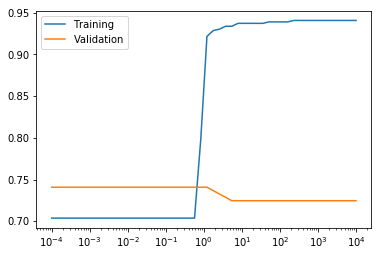

In [292]:
with open('all.pickle', 'rb') as f:
    all_df = pickle.load(f)

X = all_df.filter(all_media)
y = all_df['review_score_desc']

for desc in set(y):
    print(desc, len(y[y==desc]))

X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size=0.3, random_state=0)

def get_err_C(clf, X, y, X_cv, y_cv, C):
    clf.C = C
    clf.fit(X, y)
    return np.array([clf.score(X, y), clf.score(X_cv, y_cv)])

C = np.logspace(-4, 4, 50)
errors = np.array([get_err_C(SVC(), X_train, y_train, X_cv, y_cv, c) for c in C])
plt.semilogx(C, errors[:,0], C, errors[:,1])
plt.legend(['Training', 'Validation'])

## Prediction Accuracy

Finally, we use the tuned model to predict the data on each three data sets, and obtain the accuracy of,

1. Training Accuracy: 0.9129
2. Validation Accuracy: 0.7409
3. Testing Accuracy: 0.6997

In [291]:
svm = SVC(C=1.0)
svm.fit(X_train, y_train)
print('train score:', svm.score(X_train, y_train))
print('cv score:', svm.score(X_cv, y_cv))
print('test score:', svm.score(X_test, y_test))

train score: 0.912891986063
cv score: 0.740890688259
test score: 0.699716713881
